<a href="https://colab.research.google.com/github/glouwa/app-kandinsky-pattern-generator/blob/master/kandinsky_in_colab_Datagenerator_from_Frame.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libs and Files

In [1]:
!rm -r sample_data 
!wget https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
!wget https://github.com/Hvass-Labs/TensorFlow-Tutorials/raw/master/images/parrot_cropped1.jpg

--2019-05-25 13:39:30--  https://github.com/glouwa/app-kandinsky-pattern-generator/raw/master/lib.py
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py [following]
--2019-05-25 13:39:30--  https://raw.githubusercontent.com/glouwa/app-kandinsky-pattern-generator/master/lib.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5118 (5.0K) [text/plain]
Saving to: ‘lib.py’

lib.py              100%[===================>]   5.00K  --.-KB/s    in 0s      

2019-05-25 13:39:30 (52.6 MB/s) - ‘lib.py’ saved [5118/5118]

--2019-05-25 13:39:31--  https://github.

In [2]:
from IPython.display import display, SVG
from functools import reduce
from random import seed, randint
from numpy import array, argmax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import lib
import PIL

Using TensorFlow backend.


# Intro



## Encoding
X.shape = (samples, 224, 224, 4)

Y.shape = (samples, ?)

for y we can combine multible properies of a sample. 
the output shape is defined by their amount and encodings.


In [3]:
#@title Common Stuff { vertical-output: true } 
image_shape  = (224, 224)
input_shape  = (*image_shape, 3)
output_shape = (9)

print('input_shape', input_shape, 'output_shape', output_shape)

input_shape (224, 224, 3) output_shape 9


In [0]:
max_count       = output_shape
to_onehot       = lambda val, max_int: [1 if val == i else 0 for i in range(max_int)]
fig_path_format = './figures/%s/fig%05d.pkl'
png_path_format = './images/%s/img%05d.png'

import os 
import pickle # import sPickle as pickle

os.makedirs('./figures/', exist_ok=True)
os.makedirs('./images/', exist_ok=True)

def save_figure(path, fid, fig):
    os.makedirs('./figures/%s'%path, exist_ok=True)
    #print("create ir", path)
    dbfile = open(fig_path_format%(path, fid), 'wb+')  
    pickle.dump(fig, dbfile)               
    dbfile.close()  
    #print("saving", fig_path_format%(path, fid))
    
def load_figure(path, fid):
    dbfile = open(fig_path_format%(path, fid), 'rb')  
    fig = pickle.load(dbfile)                      
    dbfile.close()    
    return fig

def load_pil(path, fid):
    img = PIL.Image.open(png_path_format%(path, fid))
    img_resized = img.resize(image_shape, PIL.Image.LANCZOS)    
    return img_resized

def save_pil(path, fid, pil):
    os.makedirs('./images/%s'%path, exist_ok=True)
    pil.save(png_path_format%(path, fid))

def load_image(path): # used to predict image not in sets (parrot)
    img = PIL.Image.open(path)
    img_resized = img.resize(image_shape, PIL.Image.LANCZOS)    
    return array(img_resized)

count_color = lambda f, c: reduce(lambda a, e: a + (1 if e.color==c else 0), f, 0)
count_shape = lambda f, c: reduce(lambda a, e: a + (1 if e.shape==c else 0), f, 0)

# Sample *s*

In [0]:
figure_config = dict(   
    render_size = image_shape,
    obj_count=(2, 15),     
    obj_size=(.1, .7),
    colors=['red','green', 'blue', 'yellow', 'orange'],
    shapes=['circle']
)

class Sample:  
    def __init__(self, set_path, fid):        
        self.set_path = set_path
        self.fid = fid
        #self.f = f        
        
        if os.path.isfile(fig_path_format%(set_path, fid)):
            self.f = load_figure(set_path, fid)                
        else:
            self.f = lib.RandomFigure(**figure_config)
            save_figure(self.set_path, self.fid, self.f)
            
        if os.path.isfile(png_path_format%(set_path, fid)):
            pil = load_pil(self.set_path, self.fid)
        else:
            pil = lib.kandinskyFigureAsImage(self.f, width=224)
            save_pil(set_path, fid, pil)
            #pil.save(png_path_format%(set_path, fid))            
            
        self.x = {            
            'fig': self.f,
            'pil': pil,
            'arr': array(pil)/255,
            #'url': pil.save(path)
        }
        self.y_raw = {
            'pos': 'N() über x⨉y',
            '|*|': len(self.f),
            '|r|': count_color(self.f ,'red'),
            '|g|': count_color(self.f ,'green'),
            '|b|': count_color(self.f ,'blue'),
            '|◯|': count_shape(self.f ,'circle'),
            '|□|': count_shape(self.f ,'rectangle'),
            '|△|': count_shape(self.f ,'trinangle'),
            'viele kleine': True,
            'viele kleine links': True,        
        }
        self.y = {
            'encpos': to_onehot(1, 3),
            'enc|*|': to_onehot(self.y_raw['|*|'], max_count),
            'enc|r|': to_onehot(self.y_raw['|r|'], max_count),
            'enc|g|': to_onehot(self.y_raw['|g|'], max_count),
            'enc|b|': to_onehot(self.y_raw['|b|'], max_count),        
            'enc|◯|': to_onehot(self.y_raw['|◯|'], max_count),
            'enc|□|': to_onehot(self.y_raw['|□|'], max_count),
            'enc|△|': to_onehot(self.y_raw['|△|'], max_count),        
            #'|r|>|g|': True,
            #'|r|>|b|': True,
            #'|g|>|r|': False,
            #'|g|>|b|': True,
            #'|b|>|r|': False,
            #'|b|>|g|': False,        
            #'1 großes': True,
            #'1 großes rotes': True,
            #'x links von y': True,
            #'x über y': True,
            #'cap': []
        }    
    def __str__(self):
        # oooooo dreckig xD - aber wie sonst plotten?
        print(self.x['arr'].shape, "[{:.2f}…{:.2f}]".format(np.min(self.x['arr']), np.max(self.x['arr'])))        
        plt.imshow(self.x['pil'])
        plt.show()
        [print(f) for f in self.f]
        return "%s/I%d"%(self.set_path, self.fid)
        
    def compileX(self):      
        return self.x['arr']    
    
    def compileY(self):
        #return [ *self.y['enc|*|'], *self.y['enc|r|'] ]
        return [ *self.y['enc|*|'] ]
                
    def compilePandaColumns(self):
        return { 
            **{
                'shape': self.x['arr'].shape, 
                #'path': "%s/%d"%(self.set_path,self.fid),                
                #'X': self.compileX(),
                'file': "img%05d.png"%self.fid,
                'YasStr': '%d red circles'%self.y_raw['|r|']
            },
            **self.y_raw,
            **self.y
        }


Sample s= (224, 224, 3) [0.00…1.00]


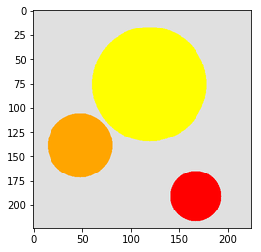

yellow circle (0.5867385235649272,0.5339602164909082,0.34149577587852975)
red circle (0.2585120429925839,0.7484490602357123,0.8544736560192565)
orange circle (0.32978234246373994,0.21571468153247444,0.6229095344887661)
single_sample/I0
pos : N() über x⨉y
|*| : 3
|r| : 1
|g| : 0
|b| : 0
|◯| : 3
|□| : 0
|△| : 0
viele kleine : True
viele kleine links : True
encpos : [0, 1, 0]
enc|*| : [0, 0, 0, 1, 0, 0, 0, 0, 0]
enc|r| : [0, 1, 0, 0, 0, 0, 0, 0, 0]
enc|g| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
enc|b| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
enc|◯| : [0, 0, 0, 1, 0, 0, 0, 0, 0]
enc|□| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
enc|△| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 250 ms, sys: 134 ms, total: 384 ms
Wall time: 263 ms


In [6]:
#@title Create a Sample { vertical-output: true, output-height: 500 }
%%time

example = Sample('single_sample', 0)
print("Sample s=", example)
[print(k, ':', v) for k, v in example.y_raw.items()];
[print(k, ':', v) for k, v in example.y.items()];

In [7]:
#@title Sample Y encoded { vertical-output: true, output-height: 500 }

example.compileY()

[0, 0, 0, 1, 0, 0, 0, 0, 0]

Sample l= (224, 224, 3) [0.00…1.00]


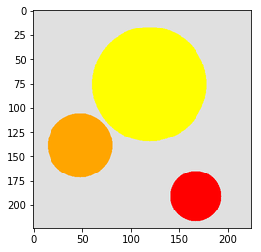

yellow circle (0.5867385235649272,0.5339602164909082,0.34149577587852975)
red circle (0.2585120429925839,0.7484490602357123,0.8544736560192565)
orange circle (0.32978234246373994,0.21571468153247444,0.6229095344887661)
single_sample/I0
pos : N() über x⨉y
|*| : 3
|r| : 1
|g| : 0
|b| : 0
|◯| : 3
|□| : 0
|△| : 0
viele kleine : True
viele kleine links : True
encpos : [0, 1, 0]
enc|*| : [0, 0, 0, 1, 0, 0, 0, 0, 0]
enc|r| : [0, 1, 0, 0, 0, 0, 0, 0, 0]
enc|g| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
enc|b| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
enc|◯| : [0, 0, 0, 1, 0, 0, 0, 0, 0]
enc|□| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
enc|△| : [1, 0, 0, 0, 0, 0, 0, 0, 0]
CPU times: user 202 ms, sys: 103 ms, total: 305 ms
Wall time: 177 ms


In [11]:
#@title Reload this Sample { vertical-output: true, output-height: 500 }
%%time

example_loaded = Sample('single_sample', 0)
print("Sample l=", example_loaded)
[print(k, ':', v) for k, v in example_loaded.y_raw.items()];
[print(k, ':', v) for k, v in example_loaded.y.items()];

 # Ok, we have a Sample class - Lets make a Batch of Samples

In [12]:
#@title First Batch { vertical-output: true }
%%time
first_batch_size = 100 #@param {type:"slider", min:1, max:200, step:5}
def generate_batch(set_path, batch_size, batch_index):  
    #print('generating', n_samples)
    X = list()
    y = list()
    c = list()
    for i in range(0, batch_size):
        n = Sample(set_path, batch_index * batch_size + i)
        X.append(n.compileX())
        y.append(n.compileY())        
        c.append(n.compilePandaColumns())    

    return array(X), array(y), pd.DataFrame(data=c)

A, b, f = generate_batch('view_batch', first_batch_size, 0)
#.filter(regex ='^enc.*').head()

display(f.filter(regex='^(?!(enc|X))').head())

,YasStr,file,pos,shape,viele kleine,viele kleine links,|*|,|b|,|g|,|r|,|□|,|△|,|◯|
0,2 red circles,img00000.png,N() über x⨉y,"(224, 224, 3)",True,True,14,3,2,2,0,0,14
1,1 red circles,img00001.png,N() über x⨉y,"(224, 224, 3)",True,True,8,1,3,1,0,0,8
2,0 red circles,img00002.png,N() über x⨉y,"(224, 224, 3)",True,True,2,1,0,0,0,0,2
3,0 red circles,img00003.png,N() über x⨉y,"(224, 224, 3)",True,True,6,3,2,0,0,0,6
4,1 red circles,img00004.png,N() über x⨉y,"(224, 224, 3)",True,True,12,2,2,1,0,0,12


CPU times: user 1.82 s, sys: 250 ms, total: 2.07 s
Wall time: 2.1 s


(100, 21)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a03e90f28>],
      dtype=object)

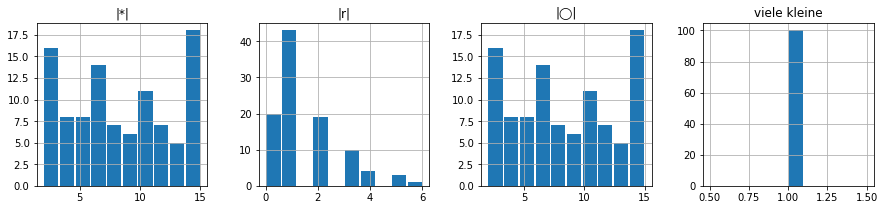

In [13]:
#@title Label Distribution of Batch, using pandaframe f { vertical-output: true }

fig = plt.figure(figsize=(15, 3))
print(f.shape)
f.hist(column='|*|',          rwidth=.9, ax=fig.add_subplot(141)) # Divide into a 1x4 grid, give first section
f.hist(column='|r|',          rwidth=.9, ax=fig.add_subplot(142))
f.hist(column='|◯|',          rwidth=.9, ax=fig.add_subplot(143))
f.hist(column='viele kleine', rwidth=.9, ax=fig.add_subplot(144))

# A Datagenerator is used to create images an figure pickles of train/test/val sets

In [0]:
# https://github.com/keras-team/keras/issues/12586
from tensorflow.python.keras.utils.data_utils import Sequence

class DataGenerator(Sequence):
#class DataGenerator(keras.utils.Sequence):  
    'Generates kandinsky data for Keras'
    def __init__(self, set_path="err", samples=1000, batch_size=32, in_dim=None, out_dim=None):        
        self.set_path = set_path
        self.n_samples = samples
        
        self.batch_size = batch_size
        
        self.in_dim = in_dim                
        self.out_dim = out_dim
        
        print('DataGenerator', self.set_path, "samples=", self.n_samples, "batchsize=", self.batch_size, "len=", int(np.floor(self.n_samples / self.batch_size)))
        
    def __len__(self):
        'Denotes the number of batches per epoch'        
        return int(np.floor(self.n_samples / self.batch_size))

    def __getitem__(self, idx): 
        #indexes = self.indexes[index * self.batch_size : (index+1) * self.batch_size]        
        #ids = ["%d"%k for k in indexes]        
        X, y, f = generate_batch(self.set_path, self.batch_size, idx)        
        self.panda = self.panda.append(f)        
        return X, y
    
    def render(self):
        self.panda = pd.DataFrame()
        for s in range(len(self)):
            self[s]
        print(len(self), self.set_path, "Batches touched")
        return self

In [15]:
#@title Data Generators for train/test/val { vertical-output: true }
%%time
batch_size      = 36 #@param {type:"slider", min:1, max:200, step:5}
training_size   = 2000 #@param {type:"slider", min:1000, max:20000, step:100}
validation_size = 200 #@param {type:"slider", min:10, max:500, step:10}
test_size       = 200 #@param {type:"slider", min:10, max:500, step:10}
            
params = {
    'batch_size': batch_size,
    'in_dim': input_shape,    
    'out_dim': output_shape
}

training_generator =   DataGenerator(set_path="train", samples=training_size, **params).render()
validation_generator = DataGenerator(set_path="test",  samples=validation_size, **params).render()
test_generator =       DataGenerator(set_path="valid", samples=test_size, **params).render()

#raining_generator.panda.filter(regex='^(?!(enc|X))').head()

DataGenerator train samples= 2000 batchsize= 36 len= 55
55 train Batches touched
DataGenerator test samples= 200 batchsize= 36 len= 5
5 test Batches touched
DataGenerator valid samples= 200 batchsize= 36 len= 5
5 valid Batches touched
CPU times: user 43.5 s, sys: 1.95 s, total: 45.4 s
Wall time: 45.4 s


In [16]:
#@title Second time sould be Faster. (images are already cached) { vertical-output: true }
%%time
training_generator =   DataGenerator(set_path="train", samples=training_size, **params).render()
validation_generator = DataGenerator(set_path="test",  samples=validation_size, **params).render()
test_generator =       DataGenerator(set_path="valid", samples=test_size, **params).render()

DataGenerator train samples= 2000 batchsize= 36 len= 55
55 train Batches touched
DataGenerator test samples= 200 batchsize= 36 len= 5
5 test Batches touched
DataGenerator valid samples= 200 batchsize= 36 len= 5
5 valid Batches touched
CPU times: user 5.84 s, sys: 240 ms, total: 6.09 s
Wall time: 6.08 s


In [17]:
#@title Label Distribution for Train/Test/Val { vertical-output: true }
print(training_generator.panda.shape)
training_generator.panda.filter(regex='^(?!(enc|X))').head()

(1980, 21)


,YasStr,file,pos,shape,viele kleine,viele kleine links,|*|,|b|,|g|,|r|,|□|,|△|,|◯|
0,2 red circles,img00000.png,N() über x⨉y,"(224, 224, 3)",True,True,5,0,0,2,0,0,5
1,1 red circles,img00001.png,N() über x⨉y,"(224, 224, 3)",True,True,6,3,1,1,0,0,6
2,3 red circles,img00002.png,N() über x⨉y,"(224, 224, 3)",True,True,10,0,3,3,0,0,10
3,1 red circles,img00003.png,N() über x⨉y,"(224, 224, 3)",True,True,8,4,1,1,0,0,8
4,0 red circles,img00004.png,N() über x⨉y,"(224, 224, 3)",True,True,2,1,0,0,0,0,2


(1980, 21)


/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8a03ab6cc0>],
      dtype=object)

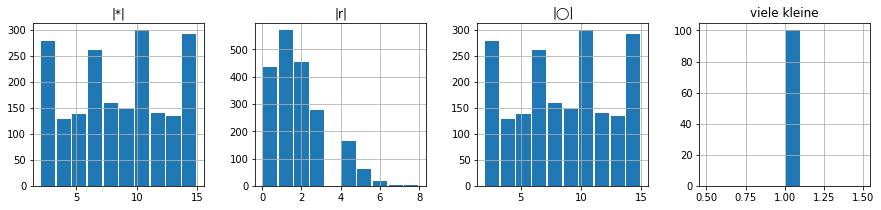

In [18]:
#@title Label Distribution for Train { vertical-output: true }

print(training_generator.panda.shape)
training_generator.panda.head()

fig = plt.figure(figsize=(15, 3))
training_generator.panda.hist(column='|*|', rwidth=.9, ax=fig.add_subplot(141))
training_generator.panda.hist(column='|r|', rwidth=.9, ax=fig.add_subplot(142))
training_generator.panda.hist(column='|◯|', rwidth=.9, ax=fig.add_subplot(143))
f.hist(column='viele kleine',               rwidth=.9, ax=fig.add_subplot(144))

# Data is ready - Time for CGG16

Instructions for updating:
Colocations handled automatically by placer.
553467904/553467096 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___

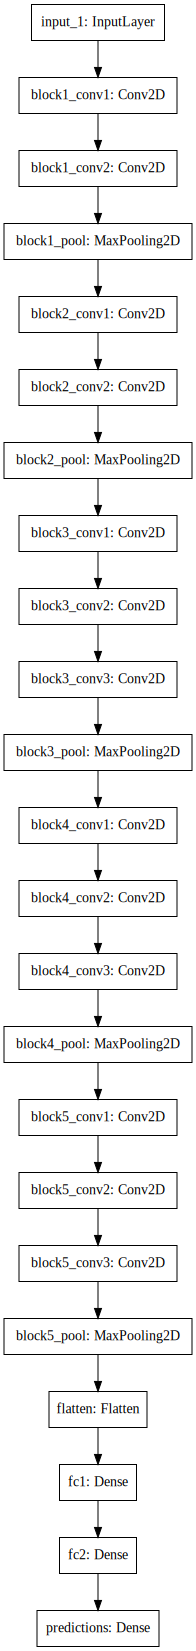

In [19]:
#@title Download VGG16 { vertical-output: true, output-height: 400 }
from tensorflow.python.keras.applications import VGG16

vgg16model = VGG16(include_top=True, weights='imagenet')
vgg16model.summary()
SVG(keras.utils.vis_utils.model_to_dot(vgg16model).create(prog='dot', format='svg'))

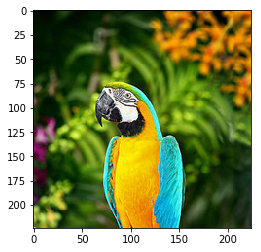

40960/35363 [==================================] - 0s 0us/step
79.02% : macaw
 6.61% : bubble
 3.64% : vine_snake
 1.90% : pinwheel
 1.22% : knot


In [20]:
#@title Make a prediction with vgg16 imagenet weights{ vertical-output: true }
import PIL
from tensorflow.python.keras.applications.vgg16 import preprocess_input, decode_predictions

def predict(image_array):
    plt.imshow(image_array)
    plt.show()
    
    img_array = np.expand_dims(image_array, axis=0)   
    
    pred = vgg16model.predict(img_array)
    pred_decoded = decode_predictions(pred)[0]
    
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))  
        
predict(load_image('parrot_cropped1.jpg'))
#predict(image_path=image_paths_train[0])

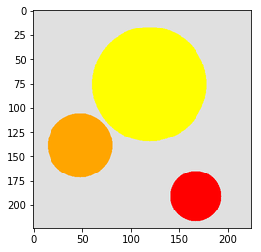

 3.90% : toilet_tissue
 3.32% : envelope
 2.55% : mosquito_net
 2.54% : ping-pong_ball
 2.38% : electric_fan


In [21]:
#@title predict a Kandinsky Figure with VGG16 imagenet weights { vertical-output: true }
predict(example.x['arr'])

# New Network

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              25691136  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 9225      
Total params: 40,415,049
Trainable params: 40,415,049
Non-trainable params: 0
_________________________________________________________________


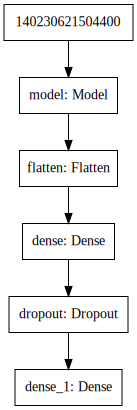

In [22]:
#@title Creating a new Model { vertical-output: true, output-height: 300 }
n1           = 100 #@param {type:"slider", min:1, max:500, step:1}
n2           = 50 #@param {type:"slider", min:1, max:500, step:1}

from tensorflow.python.keras.models import Model, Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.python.keras.optimizers import Adam, RMSprop

conv_model = Model(inputs=vgg16model.input, outputs=vgg16model.get_layer('block5_pool').output)

new_model = Sequential()
new_model.add(conv_model)
new_model.add(Flatten())
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(output_shape, activation='softmax'))

new_model.summary()
SVG(keras.utils.vis_utils.model_to_dot(new_model).create(prog='dot', format='svg'))

In [23]:
#@title Compile after Trainable Layers set { vertical-output: true }
optimizer     = "adam"                     #@param ["adam" ,"other"]
learning_rate = 1e-5 #@param {type:"slider", min:1e-7, max:0.01, step:1e-3}
loss          = "categorical_crossentropy" #@param ["categorical_crossentropy", "whatever"]
main_metric   = "categorical_accuracy"     #@param ["accuracy", "categorical_accuracy"]
train_vgg16   = False #@param {type:"boolean"}

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')

conv_model.trainable = train_vgg16
for layer in conv_model.layers: layer.trainable = train_vgg16
    
new_model.compile(optimizer=Adam(lr=1e-5), loss=loss, metrics=[main_metric])

print(' '.join([str(layer.trainable) for layer in conv_model.layers]), '\n')


True True True True True True True True True True True True True True True True True True True 

False False False False False False False False False False False False False False False False False False False 



# Training

In [24]:
from sklearn.utils.class_weight import compute_class_weight

print(np.unique(training_generator.panda['YasStr']))

class_weight = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(training_generator.panda['YasStr']),
    y = training_generator.panda['YasStr']
)

class_weight

['0 red circles' '1 red circles' '2 red circles' '3 red circles'
 '4 red circles' '5 red circles' '6 red circles' '7 red circles'
 '8 red circles']


array([  0.50691244,   0.38664323,   0.48351648,   0.79710145,
         1.34969325,   3.66666667,  12.22222222,  73.33333333,
       110.        ])

In [25]:
hist, bin_edges = np.histogram(training_generator.panda['|r|'], bins = range(output_shape))
hist

array([434, 569, 455, 276, 163,  60,  18,   5])

In [26]:
#training_generator.panda = training_generator.panda.astype({"YasStr": str})

training_generator.panda = training_generator.panda.infer_objects()

str_p = training_generator.panda[['YasStr', 'file']].astype(str)

str_p['YasStr'] = f['YasStr'].astype('category')
str_p['file'] = f['file'].astype(str)

#display(training_generator.panda.head())
display(str_p.head())

str_p.dtypes, str_p.shape


,YasStr,file
0,2 red circles,img00000.png
1,1 red circles,img00001.png
2,0 red circles,img00002.png
3,0 red circles,img00003.png
4,1 red circles,img00004.png


(YasStr    category
 file        object
 dtype: object, (1980, 2))

In [27]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
argumented_training_generator = ImageDataGenerator(      
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=[0.9, 1.5],  
    fill_mode='nearest'
)

print("file table shape (str_p)", str_p.shape)
training_generator_2 = argumented_training_generator.flow_from_dataframe(
    dataframe = str_p,
    directory = './images/train/',
    x_col = 'file',
    y_col = 'YasStr', #'|r|', # ja wirklich nicht Y, weil ImageDataGenerator im categorical mode automatisch zu onehot convertiert (wenn man ihm auch die classes gibt?)
    # 'categorical' for string?
    # 'other' for  if Y is int
    class_mode = 'other',     
    batch_size = 32,
    target_size = image_shape    
)

#training_generator_2.n, len(training_generator_2.filenames), training_generator_2.classes, list(training_generator_2.class_indices.keys()) #, training_generator_2.num_classes

file table shape (str_p) (1980, 2)
Found 36 images.


In [0]:
#@title Training { vertical-output: true }
%%time
steps_per_epoch    = 100 #@param {type:"slider", min:10, max:1000, step:1}
epochs             = 12 #@param {type:"slider", min:2, max:50, step:1}
use_multprocessing = False #@param {type:"boolean"}
workers            = 16 #@param {type:"slider", min:1, max:64, step:1}
verbose            = 1 #@param {type:"slider", min:0, max:5, step:1}

#flow_from_dataframe(panda, "train")
#training_generator
#datagen.flow(x_train, y_train, batch_size=32)

#https://keras.io/preprocessing/image/
#model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
#                    steps_per_epoch=len(x_train) / 32, epochs=epochs)

history = new_model.fit_generator(    
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    generator = training_generator,  
    validation_data = validation_generator,
    class_weight = class_weight,
    use_multiprocessing = use_multprocessing,    
    workers = workers,
    verbose = verbose
)

lib.plot_history_categorical(history)


# Training done - Time for Evaluation

In [0]:
#@title Evaluate { vertical-output: true }
max_errors = 18 #@param {type:"slider", min:1, max:20, step:1}


# evaluate on some new patterns
X, y, f = generate_batch("eval", 1000, alphabet)
print(X.shape, y.shape)

result = model.predict(X, verbose=1)

expected =  [sample_decode(s) for s in y]
predicted = [sample_decode(s) for s in result]

c = 0
for i in range(0, len(result)):
    if expected[i] != predicted[i]:
        c = c + 1
        if c < max_errors:
            print('Expected=%s, Predicted=%s' % (expected[i], predicted[i]))
            
print("expected != predicted Count:", c)

In [0]:
example_errors()

In [0]:
#@title Test Metrics { vertical-output: true }
"Accuracy %s" % new_model.evaluate_generator(test_generator)[1]

In [0]:
#@title  { vertical-output: true }
def calculate(inp):
    print(inp, '=')
    padded = padd(inp, in_seq_len)  
    X = array([sample_encode(padded)])  
    result = model.predict(X)
    return sample_decode(result[0])

calculate('12+3')


In [0]:
example_errors()

In [0]:
# Load the first images from the train-set.
images = load_images(image_paths=image_paths_train[0:9])

# Get the true classes for those images.
cls_true = cls_train[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, smooth=True)

In [0]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict_generator(generator_test,
                                         steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [0]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [0]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))

In [0]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()